# Country Clustering Comparison
This notebook compares K-Means, Hierarchical, and DBSCAN clustering algorithms on socio-economic country data.

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
import sys
sys.path.append('../src')  
from utils import plot_clusters

In [2]:
# Load data
df = pd.read_csv('../data/country-data.csv')
countries = df['country']
X = df.drop('country', axis=1)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 1. K-Means Clustering

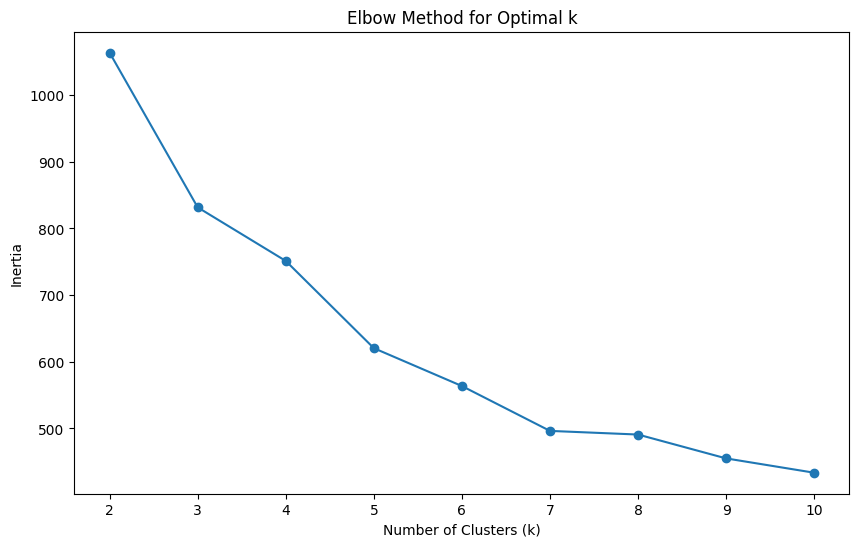

In [3]:
# Find optimal k using the Elbow Method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [4]:
# Choose k=3 based on the elbow curve
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

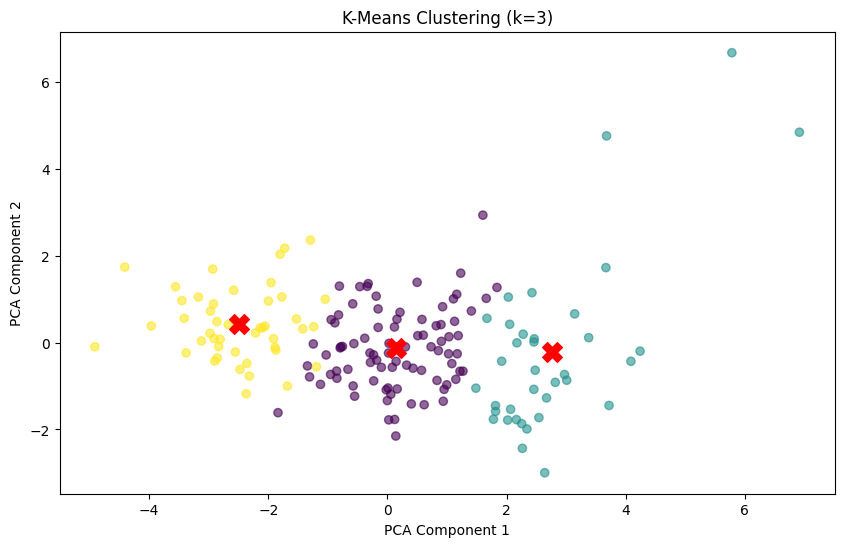

In [5]:
plot_clusters(X_scaled, kmeans_labels, kmeans.cluster_centers_, 'K-Means Clustering (k=3)')

## 2. Hierarchical Clustering

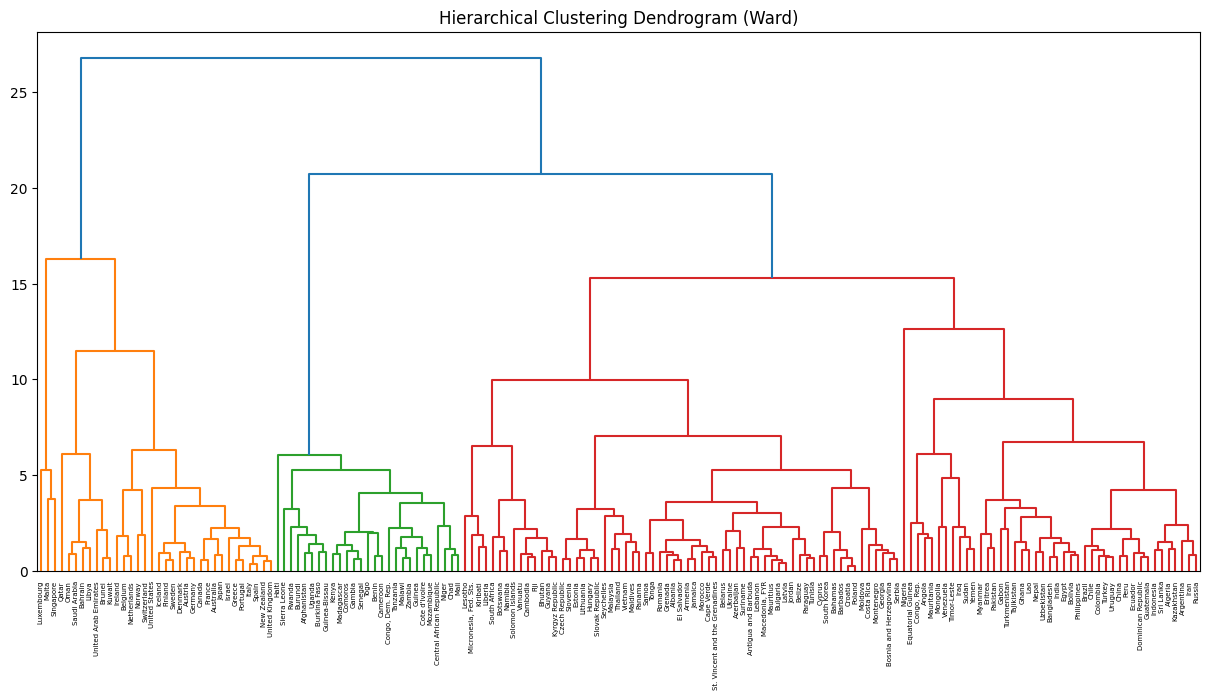

In [6]:
# Plot dendrogram
plt.figure(figsize=(15, 7))
Z = linkage(X_scaled, method='ward')
dendrogram(Z, labels=countries.values, orientation='top', leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.show()

In [6]:
# Cut dendrogram to get 3 clusters
hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_labels = hierarchical.fit_predict(X_scaled)

## 3. DBSCAN Clustering

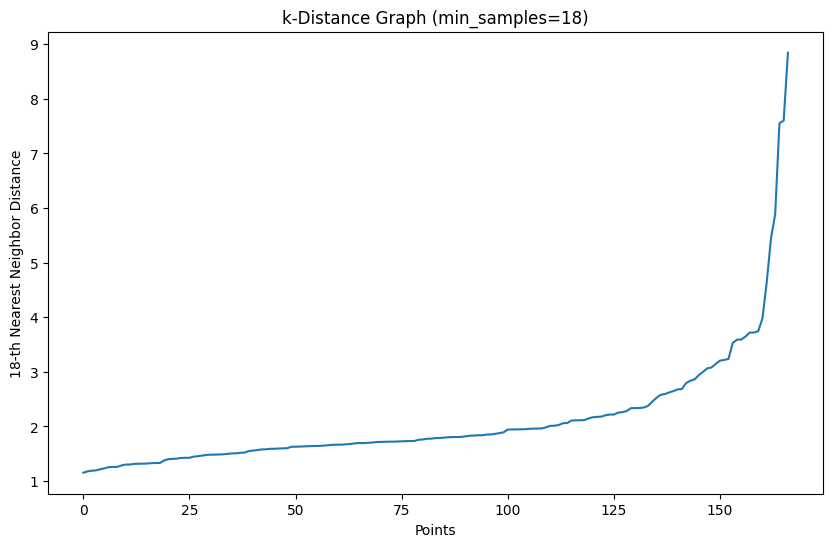

In [7]:
# Tune eps using k-distance graph
min_samples = 2 * X.shape[1]  # 2 * number of features
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, _ = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, min_samples-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title(f'k-Distance Graph (min_samples={min_samples})')
plt.xlabel('Points')
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance')
plt.show()

In [14]:
# Run DBSCAN with tuned eps=2.5 (adjust based on the k-distance graph)
dbscan = DBSCAN(eps=2.5, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)

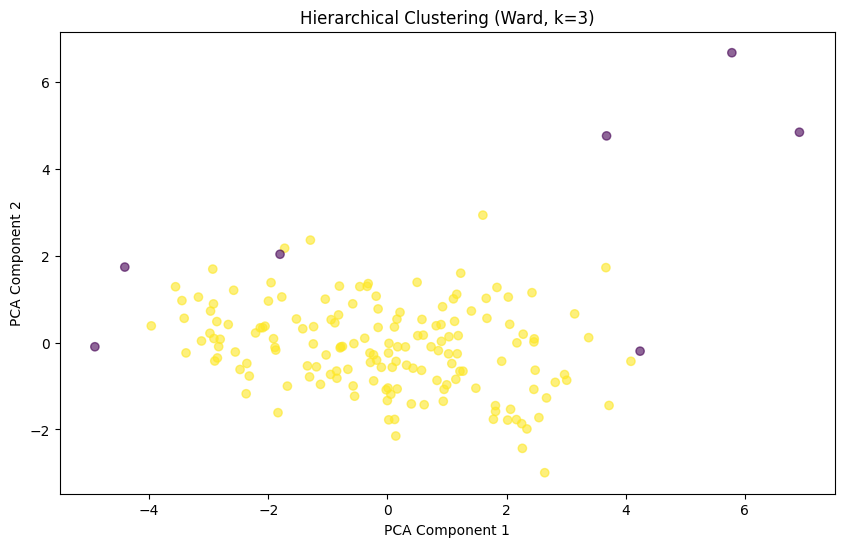

In [15]:
plot_clusters(X_scaled, dbscan_labels, None, 'Hierarchical Clustering (Ward, k=3)')

## Visualization and Comparison

### A. Dimensionality Reduction (PCA + t-SNE)

In [16]:
# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Reduce to 2D using t-SNE (slower but better for visualization)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

### B. Cluster Visualization

In [17]:
def plot_clusters_2D(X_embedded, labels, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter)
    plt.show()

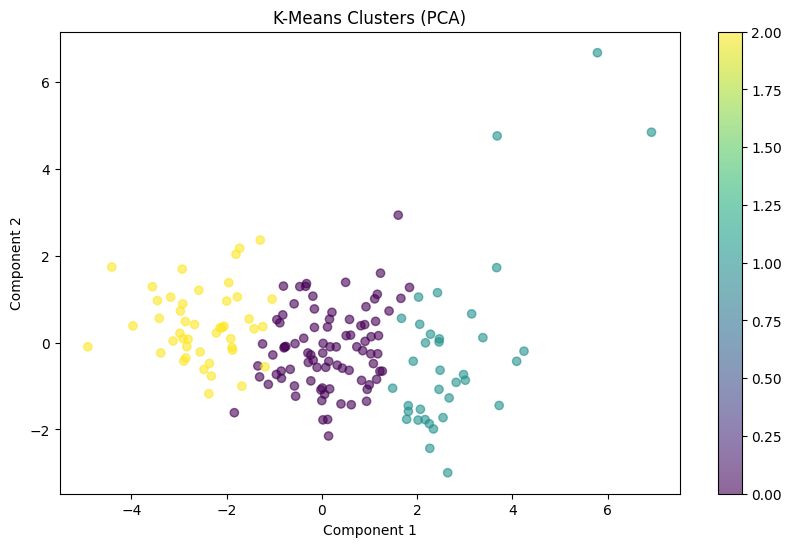

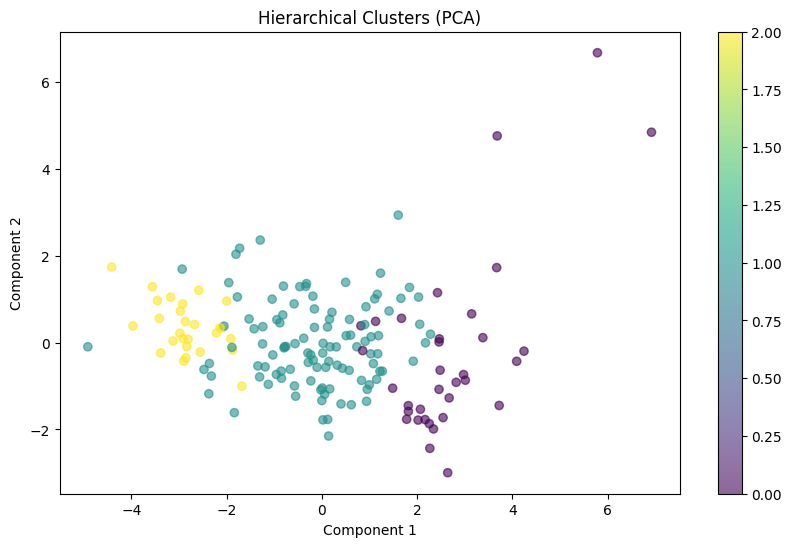

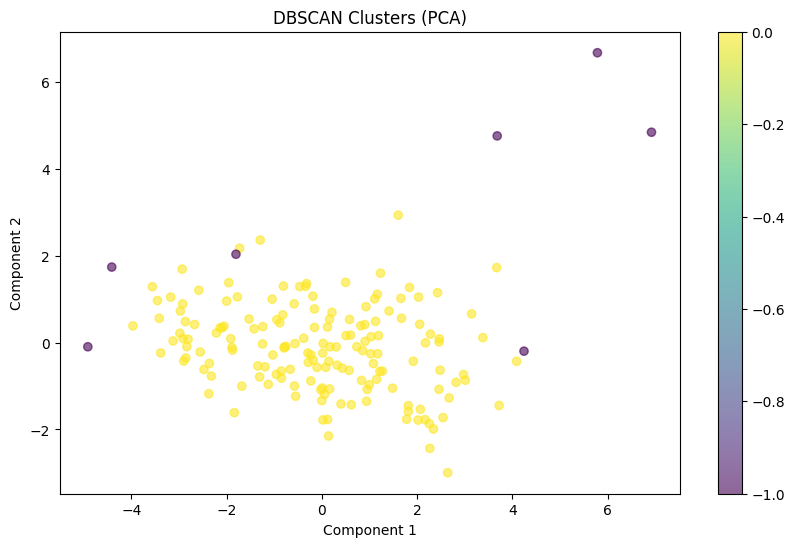

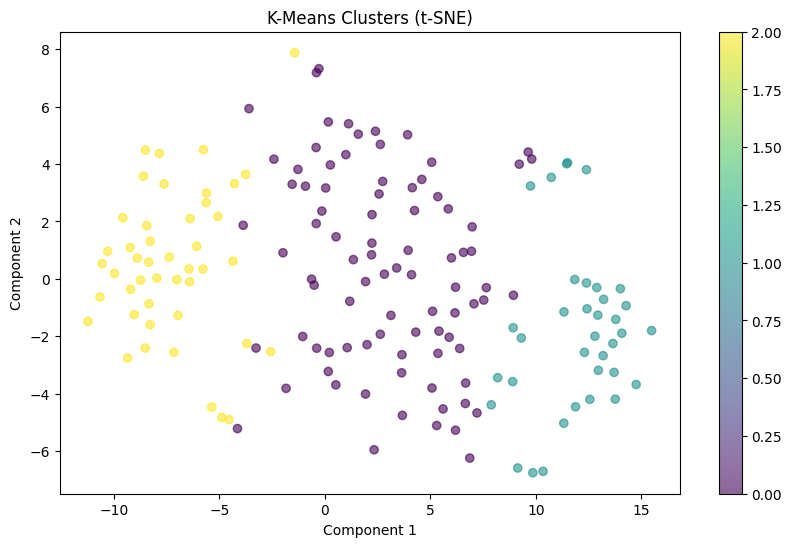

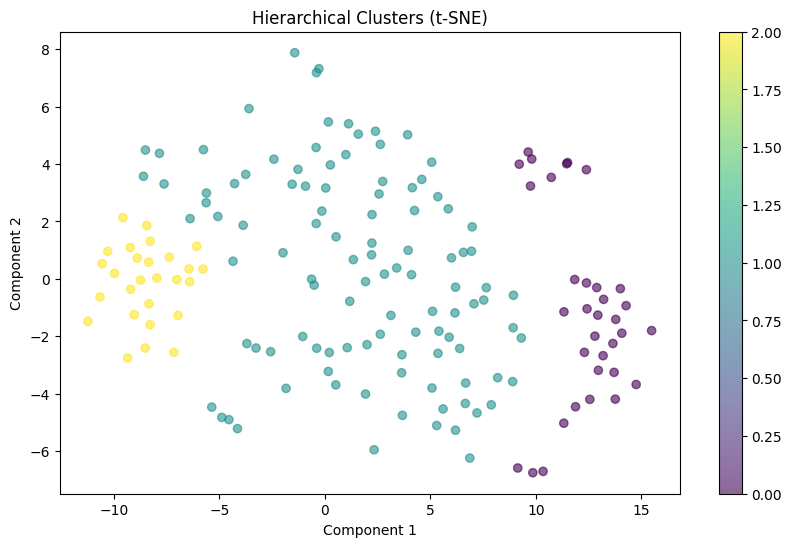

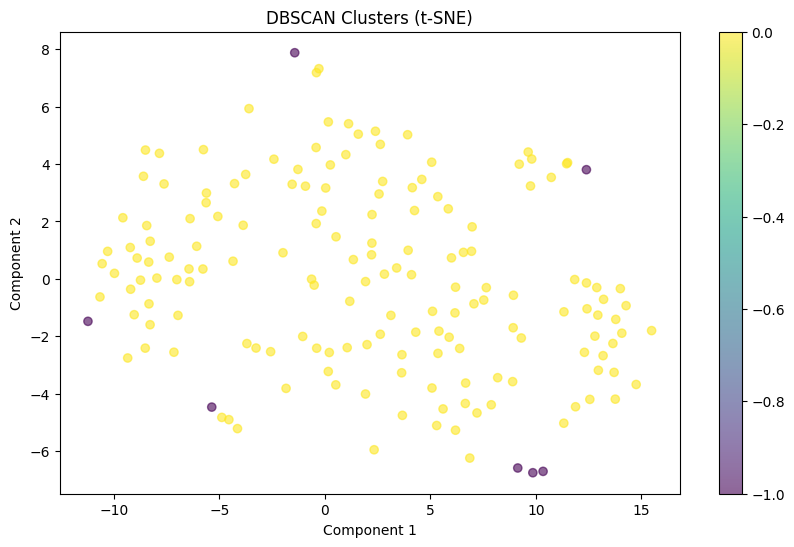

In [20]:
# Plot PCA results
plot_clusters_2D(X_pca, kmeans_labels, 'K-Means Clusters (PCA)')
plot_clusters_2D(X_pca, hierarchical_labels, 'Hierarchical Clusters (PCA)')
plot_clusters_2D(X_pca, dbscan_labels, 'DBSCAN Clusters (PCA)')

# Plot t-SNE results
plot_clusters_2D(X_tsne, kmeans_labels, 'K-Means Clusters (t-SNE)')
plot_clusters_2D(X_tsne, hierarchical_labels, 'Hierarchical Clusters (t-SNE)')
plot_clusters_2D(X_tsne, dbscan_labels, 'DBSCAN Clusters (t-SNE)')

### C. Quantitative Metrics

In [21]:
def evaluate_clusters(labels, algorithm_name):
    if len(np.unique(labels)) < 2:
        print(f"{algorithm_name}: Only one cluster. Metrics skipped.")
        return
    
    print(f"Metrics for {algorithm_name}:")
    print(f" - Silhouette Score: {silhouette_score(X_scaled, labels):.3f}")
    print(f" - Davies-Bouldin Index: {davies_bouldin_score(X_scaled, labels):.3f}")
    print(f" - Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, labels):.3f}\n")

In [22]:
evaluate_clusters(kmeans_labels, 'K-Means')
evaluate_clusters(hierarchical_labels, 'Hierarchical')
evaluate_clusters(dbscan_labels, 'DBSCAN')

Metrics for K-Means:
 - Silhouette Score: 0.286
 - Davies-Bouldin Index: 1.274
 - Calinski-Harabasz Score: 66.215

Metrics for Hierarchical:
 - Silhouette Score: 0.246
 - Davies-Bouldin Index: 1.300
 - Calinski-Harabasz Score: 50.716

Metrics for DBSCAN:
 - Silhouette Score: 0.531
 - Davies-Bouldin Index: 2.280
 - Calinski-Harabasz Score: 11.914



### D. Cluster Profiles

In [23]:
# Add cluster labels to the dataframe
df['kmeans_cluster'] = kmeans_labels
df['hierarchical_cluster'] = hierarchical_labels
df['dbscan_cluster'] = dbscan_labels

In [25]:
# K-Means Profile
print("K-Means Cluster Averages:")
print(df.drop('country', axis=1).groupby('kmeans_cluster').mean())

K-Means Cluster Averages:
                child_mort    exports    health    imports        income  \
kmeans_cluster                                                             
0                22.456977  40.273128  6.251047  47.362394  12321.744186   
1                 5.000000  58.738889  8.807778  51.491667  45672.222222   
2                95.106667  28.602444  6.301111  42.306667   3539.844444   

                inflation  life_expec  total_fer          gdpp  \
kmeans_cluster                                                   
0                7.720884   72.566279   2.340349   6461.767442   
1                2.671250   80.127778   1.752778  42494.444444   
2               11.986778   59.055556   5.065333   1766.711111   

                hierarchical_cluster  dbscan_cluster  
kmeans_cluster                                        
0                           0.965116        0.000000  
1                           0.138889       -0.111111  
2                           1.600000      

In [26]:
# Hierarchical Profile
print("Hierarchical Cluster Averages:")
print(df.drop('country', axis=1).groupby('hierarchical_cluster').mean())

Hierarchical Cluster Averages:
                      child_mort    exports    health    imports  \
hierarchical_cluster                                               
0                       5.961765  58.508824  8.501176  48.902941   
1                      31.617925  39.990368  6.353679  48.085527   
2                     105.070370  23.589630  6.507037  39.662963   

                            income  inflation  life_expec  total_fer  \
hierarchical_cluster                                                   
0                     47588.235294   4.115500   79.982353   1.888529   
1                     11341.886792   9.120604   70.921698   2.654623   
2                      1589.740741   7.142778   57.248148   5.433704   

                              gdpp  kmeans_cluster  dbscan_cluster  
hierarchical_cluster                                                
0                     43170.588235        0.911765       -0.117647  
1                      6407.367925        0.386792       -0.

In [27]:
# DBSCAN Profile
print("DBSCAN Cluster Averages:")
print(df.drop('country', axis=1).groupby('dbscan_cluster').mean())

DBSCAN Cluster Averages:
                child_mort    exports    health    imports       income  \
dbscan_cluster                                                            
-1               65.585714  95.757143  6.467143  96.700000  46590.00000   
 0               37.075000  38.718119  6.830938  44.711037  15856.45625   

                inflation  life_expec  total_fer          gdpp  \
dbscan_cluster                                                   
-1              18.283429   66.128571   2.668571  35308.857143   
 0               7.322388   70.749375   2.960187  11986.575000   

                kmeans_cluster  hierarchical_cluster  
dbscan_cluster                                        
-1                    1.428571              0.571429  
 0                    0.725000              0.975000  


In [28]:
# DBSCAN Noise Analysis
print("\nDBSCAN Outliers (Noise):")
print(df[df['dbscan_cluster'] == -1][['country', 'gdpp', 'child_mort', 'income']])


DBSCAN Outliers (Noise):
        country    gdpp  child_mort  income
66        Haiti     662       208.0    1500
87      Lesotho    1170        99.7    2380
91   Luxembourg  105000         2.8   91700
98        Malta   21100         6.8   28300
113     Nigeria    2330       130.0    5150
123       Qatar   70300         9.0  125000
133   Singapore   46600         2.8   72100


In [39]:
df[df["hierarchical_cluster"]==0]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_cluster,hierarchical_cluster,dbscan_cluster
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,1,0,0
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,1,0,0
11,Bahrain,8.6,69.5,4.97,50.9,41100,7.440,76.0,2.16,20700,1,0,0
15,Belgium,4.5,76.4,10.70,74.7,41100,1.880,80.0,1.86,44400,1,0,0
23,Brunei,10.5,67.4,2.84,28.0,80600,16.700,77.1,1.84,35300,1,0,0
29,Canada,5.6,29.1,11.30,31.0,40700,2.870,81.3,1.63,47400,1,0,0
44,Denmark,4.1,50.5,11.40,43.6,44000,3.220,79.5,1.87,58000,1,0,0
53,Finland,3.0,38.7,8.95,37.4,39800,0.351,80.0,1.87,46200,1,0,0
54,France,4.2,26.8,11.90,28.1,36900,1.050,81.4,2.03,40600,1,0,0
58,Germany,4.2,42.3,11.60,37.1,40400,0.758,80.1,1.39,41800,1,0,0


## 6. Summary of Results
| Algorithm          | Silhouette Score | Davies-Bouldin | Calinski-Harabasz | Key Insights                          |
|--------------------|------------------|----------------|-------------------|---------------------------------------|
| **K-Means**        | 0.286            | 1.274          | 66.215            | Clear separation into 3 tiers.        |
| **Hierarchical**   | 0.246            | 1.300          | 50.716            | Similar to K-Means but slightly different.|
| **DBSCAN**         | 0.531            | 2.280          | 11.914              | Detects outliers (e.g., Qatar, Niger).|

## 7. Conclusion
- **K-Means** is the best choice for clear, tiered country categorization.
- **DBSCAN** is useful for identifying outliers but struggles with the dataset’s density structure.
- **Hierarchical** provides similar results to K-Means but with dendrogram insights.